In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
from pandas.tseries.offsets import *
from datetime import datetime, timedelta

C:\Users\YH817GQ\Anaconda3_new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_series(time,series,format='-'):
    plt.figure(figsize=(0,6)).set_figwidth(15)
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time,series_num,format)
    else:
        plt.plot(time,series,format)
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show

In [3]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['close']).iloc[:size]
    x_test = data.drop(columns=['close']).iloc[size:]
    y_train = data['close'].iloc[:size]
    y_test = data['close'].iloc[size:]
    return x_train,x_test,y_train,y_test



def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(df_temp.shift(i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df_temp.shift(-1))
        if i==0:
            names+=[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train,1,1)
    reframed_test = series_to_supervised(test,1,1)
    
    train = reframed_train.values
    test = reframed_test.values
    
    train_X,y_train = train[:,:-1],train[:,-1]
    test_X,y_test = test[:,:-1], test[:,-1]
    
    x_train = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    return x_train,x_test,y_train,y_test




In [4]:
df = pd.read_excel('niit.xlsx')

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek+1
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df = pd.get_dummies(df,columns=['weekday','month','quarter'])
# df.drop(columns=['Open', 'High', 'Low', 'Adj Close'],axis=1,inplace=True)
df = df[~df.isna()]
df = df.sort_values('date')
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-01-02,22.770,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-01-03,24.700,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-01-04,23.780,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-01-05,25.430,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-01-08,26.070,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


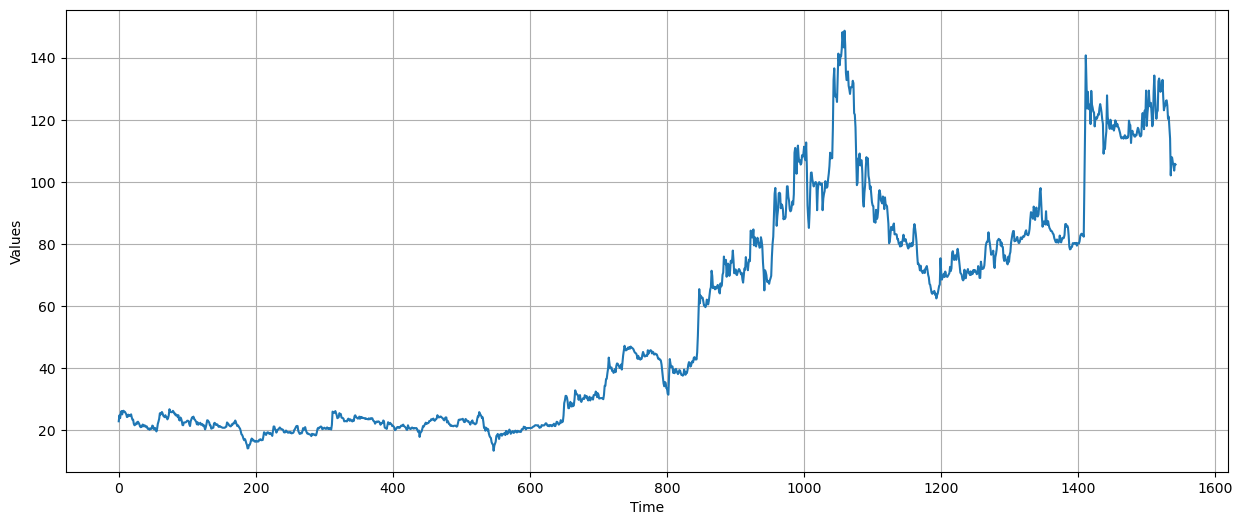

In [5]:
time = np.arange(len(df['close']))
series = df['close']
plot_series(time,series)

In [6]:
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2018-01-02,22.770,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2018-01-03,24.700,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2018-01-04,23.780,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2018-01-05,25.430,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2018-01-08,26.070,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [7]:
df = df.set_index('date')
df.head(10)

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,22.770,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-03,24.700,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-04,23.780,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-05,25.430,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-08,26.070,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-09,24.990,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-10,26.050,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-11,26.160,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-12,25.880,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
df.columns

Index(['close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4'],
      dtype='object')

In [9]:
df1 = series_to_supervised(df[['close']],30,30).merge(df,how='left',on='date')
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-15,22.770,24.700,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.860,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-02-16,24.700,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,21.150,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-02-19,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,20.870,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-02-20,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,20.870,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.320,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-02-21,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,20.870,21.320,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.060,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [10]:
df1.columns

Index(['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)',
       'var1(t+10)', 'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)',
       'var1(t+15)', 'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)',
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_

In [11]:
len(df1.columns)

84

In [12]:
df1 = df1[['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4','var1(t)', 'var1(t+1)', 'var1(t+2)', 'var1(t+3)', 'var1(t+4)',
       'var1(t+5)', 'var1(t+6)', 'var1(t+7)', 'var1(t+8)', 'var1(t+9)',
       'var1(t+10)', 'var1(t+11)', 'var1(t+12)', 'var1(t+13)', 'var1(t+14)',
       'var1(t+15)', 'var1(t+16)', 'var1(t+17)', 'var1(t+18)', 'var1(t+19)',
       'var1(t+20)', 'var1(t+21)', 'var1(t+22)', 'var1(t+23)', 'var1(t+24)',
       'var1(t+25)', 'var1(t+26)', 'var1(t+27)', 'var1(t+28)', 'var1(t+29)']]
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9),var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19),var1(t+20),var1(t+21),var1(t+22),var1(t+23),var1(t+24),var1(t+25),var1(t+26),var1(t+27),var1(t+28),var1(t+29)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-15,22.770,24.700,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150,21.150
2018-02-16,24.700,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870,20.870
2018-02-19,23.780,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,20.870,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320,21.320
2018-02-20,25.430,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,20.870,21.320,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060,21.060
2018-02-21,26.070,24.990,26.050,26.160,25.880,25.830,25.430,25.010,24.130,24.220,24.910,24.510,24.760,24.640,25.010,24.020,23.270,23.300,21.950,21.480,21.620,21.800,22.370,21.990,22.630,22.290,21.860,21.150,20.870,21.320,21.060,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720,21.720


In [13]:
df_X,df_Y = df1.values[:,:-30],df1.values[:,-30:]

In [14]:
df_X


array([[ 22.77,  24.7 ,  23.78, ...,   0.  ,   0.  ,   0.  ],
       [ 24.7 ,  23.78,  25.43, ...,   0.  ,   0.  ,   0.  ],
       [ 23.78,  25.43,  26.07, ...,   0.  ,   0.  ,   0.  ],
       ...,
       [118.8 , 128.9 , 134.25, ...,   0.  ,   0.  ,   0.  ],
       [128.9 , 134.25, 128.  , ...,   0.  ,   0.  ,   0.  ],
       [134.25, 128.  , 122.9 , ...,   0.  ,   0.  ,   0.  ]])

In [15]:
df_Y

array([[ 21.15,  21.15,  21.15, ...,  21.15,  21.15,  21.15],
       [ 20.87,  20.87,  20.87, ...,  20.87,  20.87,  20.87],
       [ 21.32,  21.32,  21.32, ...,  21.32,  21.32,  21.32],
       ...,
       [103.6 , 103.6 , 103.6 , ..., 103.6 , 103.6 , 103.6 ],
       [105.8 , 105.8 , 105.8 , ..., 105.8 , 105.8 , 105.8 ],
       [105.55, 105.55, 105.55, ..., 105.55, 105.55, 105.55]])

In [16]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])
Y = df_Y

In [17]:
X.shape,Y.shape

((1512, 1, 54), (1512, 30))

In [18]:
X

array([[[ 22.77,  24.7 ,  23.78, ...,   0.  ,   0.  ,   0.  ]],

       [[ 24.7 ,  23.78,  25.43, ...,   0.  ,   0.  ,   0.  ]],

       [[ 23.78,  25.43,  26.07, ...,   0.  ,   0.  ,   0.  ]],

       ...,

       [[118.8 , 128.9 , 134.25, ...,   0.  ,   0.  ,   0.  ]],

       [[128.9 , 134.25, 128.  , ...,   0.  ,   0.  ,   0.  ]],

       [[134.25, 128.  , 122.9 , ...,   0.  ,   0.  ,   0.  ]]])

In [19]:
Y

array([[ 21.15,  21.15,  21.15, ...,  21.15,  21.15,  21.15],
       [ 20.87,  20.87,  20.87, ...,  20.87,  20.87,  20.87],
       [ 21.32,  21.32,  21.32, ...,  21.32,  21.32,  21.32],
       ...,
       [103.6 , 103.6 , 103.6 , ..., 103.6 , 103.6 , 103.6 ],
       [105.8 , 105.8 , 105.8 , ..., 105.8 , 105.8 , 105.8 ],
       [105.55, 105.55, 105.55, ..., 105.55, 105.55, 105.55]])

In [20]:
size = int(len(X)*0.8)
x_train = X[:size]
y_train = Y[:size]

x_test = X[size:]
y_test = Y[size:]

In [21]:
x_train.shape,y_train.shape

((1209, 1, 54), (1209, 30))

In [22]:
x_test.shape,y_test.shape

((303, 1, 54), (303, 30))

In [23]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30))
model.compile(loss='mae',optimizer='adam')
history = model.fit(x_train,y_train,epochs=30,batch_size=50,verbose=1,shuffle=False)



Epoch 1/30

25/25 [==============================] - 4s 7ms/step - loss: 17.8432
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 5.6001
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 4.7438
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 4.6916
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 4.4076
Epoch 6/30
25/25 [==============================] - 0s 6ms/step - loss: 4.3635
Epoch 7/30
25/25 [==============================] - 0s 6ms/step - loss: 4.1689
Epoch 8/30
25/25 [==============================] - 0s 6ms/step - loss: 3.9649
Epoch 9/30
25/25 [==============================] - 0s 6ms/step - loss: 3.5867
Epoch 10/30
25/25 [==============================] - 0s 6ms/step - loss: 3.1669
Epoch 11/30
25/25 [==============================] - 0s 6ms/step - loss: 3.1897
Epoch 12/30
25/25 [==============================] - 0s 6ms/step - loss: 3.7992
Epoch 13/30
25/25 [==========================

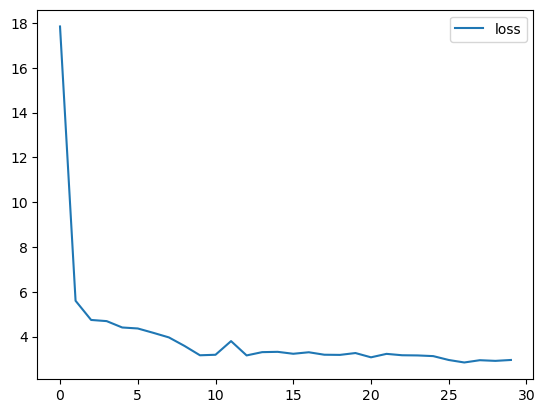

In [24]:
# Plot loss history
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

In [25]:
y_test_pre = model.predict(x_test)
y_test_pre.shape,y_test.shape

10/10 [==============================] - 1s 5ms/step


((303, 30), (303, 30))

In [26]:
y_test_pre.shape

(303, 30)

In [27]:
y_test.shape

(303, 30)

In [28]:
# Make predictions
pred = pd.DataFrame()
pred['date'] = df1.reset_index()['date'][size:]
pred['predicted_close'] = list(pd.DataFrame(y_test_pre).iloc[:,0])
pred['actual_close'] = list(pd.DataFrame(y_test).iloc[:,0])
pred.head()

,date,predicted_close,actual_close
1209,2023-01-03,69.243,70.560
1210,2023-01-04,70.035,70.550
1211,2023-01-05,69.867,69.910
1212,2023-01-06,69.051,71.120
1213,2023-01-09,69.795,70.030


3.472840321682696

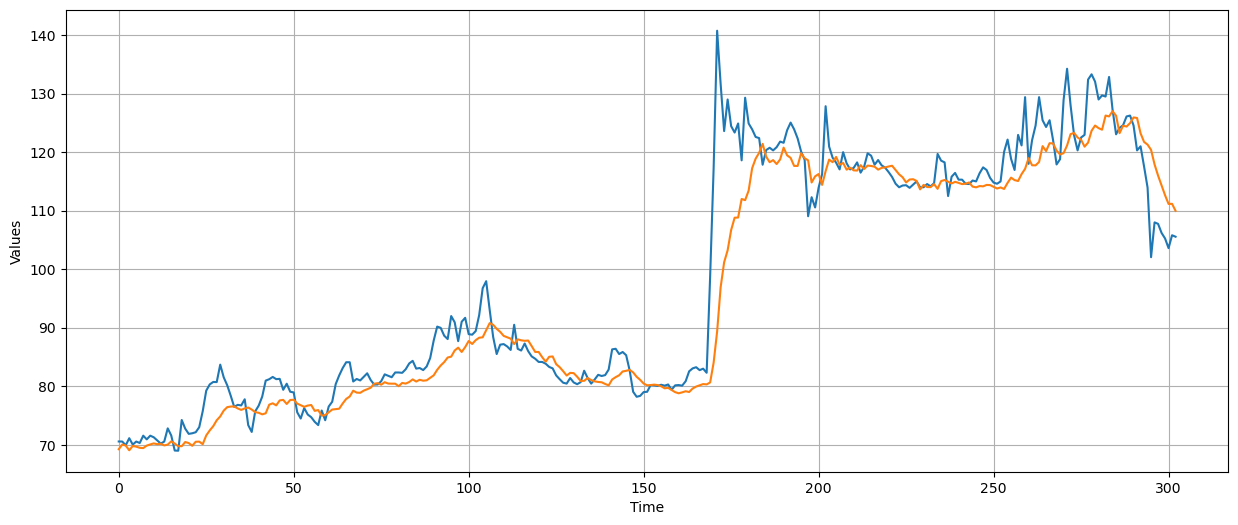

In [29]:
def measure_mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

time = np.arange(len(pred))
series1 = pred['actual_close']
series2 = pred['predicted_close']
plot_series(time,(series1,series2))
display(measure_mape(series1,series2))

In [30]:
## oot forecastingo

In [31]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30))
model.compile(loss='mae',optimizer='adam')
history = model.fit(X,Y,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
31/31 [==============================] - 3s 6ms/step - loss: 15.4960
Epoch 2/30
31/31 [==============================] - 0s 6ms/step - loss: 6.2078
Epoch 3/30
31/31 [==============================] - 0s 6ms/step - loss: 11.4007
Epoch 4/30
31/31 [==============================] - 0s 6ms/step - loss: 6.6623
Epoch 5/30
31/31 [==============================] - 0s 6ms/step - loss: 6.1991
Epoch 6/30
31/31 [==============================] - 0s 6ms/step - loss: 6.1526
Epoch 7/30
31/31 [==============================] - 0s 6ms/step - loss: 5.6477
Epoch 8/30
31/31 [==============================] - 0s 6ms/step - loss: 5.9126
Epoch 9/30
31/31 [==============================] - 0s 6ms/step - loss: 5.4340
Epoch 10/30
31/31 [==============================] - 0s 6ms/step - loss: 5.8598
Epoch 11/30
31/31 [==============================] - 0s 6ms/step - loss: 5.7074
Epoch 12/30
31/31 [==============================] - 0s 6ms/step - loss: 5.6899
Epoch 13/30
31/31 [============================

In [32]:
df1 = series_to_supervised(df[['close']].tail(31),30,0).merge(df,how='left',on='date')
df1

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,128.000,122.900,120.300,122.500,122.950,132.400,133.300,132.050,129.000,129.700,129.500,132.850,127.250,123.050,124.150,124.600,126.100,126.250,124.550,120.300,121.000,117.550,113.950,102.050,108.000,107.750,106.200,105.250,103.600,105.800,105.550,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [33]:
len(df1.columns)

54

In [34]:
df1 = df1[['var1(t-30)', 'var1(t-29)', 'var1(t-28)', 'var1(t-27)', 'var1(t-26)',
       'var1(t-25)', 'var1(t-24)', 'var1(t-23)', 'var1(t-22)', 'var1(t-21)',
       'var1(t-20)', 'var1(t-19)', 'var1(t-18)', 'var1(t-17)', 'var1(t-16)',
       'var1(t-15)', 'var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)',
       'var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)',
       'close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4']]
df1.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),var1(t-20),var1(t-19),var1(t-18),var1(t-17),var1(t-16),var1(t-15),var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-22,128.000,122.900,120.300,122.500,122.950,132.400,133.300,132.050,129.000,129.700,129.500,132.850,127.250,123.050,124.150,124.600,126.100,126.250,124.550,120.300,121.000,117.550,113.950,102.050,108.000,107.750,106.200,105.250,103.600,105.800,105.550,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [35]:
df_X = df1.values[:,:]

In [36]:
df_X.shape

(1, 54)

In [37]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])

In [38]:
X.shape

(1, 1, 54)

In [39]:
X

array([[[128.  , 122.9 , 120.3 , 122.5 , 122.95, 132.4 , 133.3 , 132.05,
         129.  , 129.7 , 129.5 , 132.85, 127.25, 123.05, 124.15, 124.6 ,
         126.1 , 126.25, 124.55, 120.3 , 121.  , 117.55, 113.95, 102.05,
         108.  , 107.75, 106.2 , 105.25, 103.6 , 105.8 , 105.55,   0.  ,
           0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
           0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ]]])

In [44]:
d = pd.DataFrame()
d['eod_date'] = pd.bdate_range(start=pd.to_datetime('2024-03-24'),end=pd.to_datetime('2024-03-25')+pd.DateOffset(41))
d['forecast'] = model.predict(X)[0]

1/1 [==============================] - 0s 23ms/step


In [45]:
d

,eod_date,forecast
0,2024-03-25,104.957
1,2024-03-26,104.494
2,2024-03-27,104.663
3,2024-03-28,103.839
4,2024-03-29,104.318
5,2024-04-01,103.889
6,2024-04-02,105.055
7,2024-04-03,103.856
8,2024-04-04,104.780
9,2024-04-05,105.186


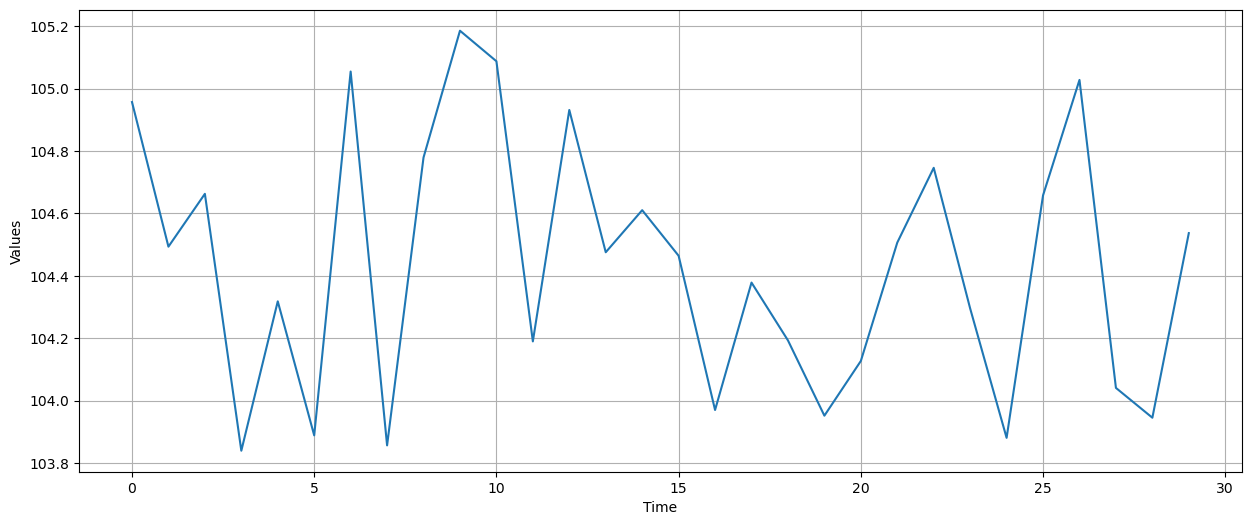

In [42]:
time = np.arange(len(d))
series1 = d['forecast']
# series2 = pred['predicted_close']
plot_series(time,(series1))
# display(measure_mape(series1,series2))